# 모델 구조
* 주요 참고 hugging face official [code](https://github.com/huggingface/transformers/blob/3dc82427166239e2764196c07fa4c5dcc25b1590/src/transformers/models/roberta/modeling_roberta.py#L39)
* 이전 기수 custom 변경 참고 [code1](https://github.com/boostcampaitech2/klue-level2-nlp-13/blob/2cd72e1627a9808e87214027ed8b61cdfd10e091/models.py), [code2](https://github.com/boostcampaitech2/klue-level2-nlp-14/blob/5154eca96ee9b7f17e5544c54d578ae1f10df401/solution/models/modeling_roberta.py#L47)


## 간단한 기본 구조 : [transformer 소스](https://github.com/huggingface/transformers/tree/3dc82427166239e2764196c07fa4c5dcc25b1590/src/transformers) 
* 소스 코드의 해당 폴더에 trainer, trainer_callback(wandb, early stopping 등 기능 수행), modeling_utils(모델 weight 불러오고, attention 처리하는 등의 모델링에 필요한 helper function) 존재
* `models/` 에 들어가면 모델별로 폴더가 있고, 해당 모델폴더에 들어가면 그 모델이 사용한 tokenizer와 modeling_{모델이름} 으로 파일이 구성돼있습니다.

## Roberta 구조 개괄: [modeling_roberta.py](https://github.com/huggingface/transformers/blob/3dc82427166239e2764196c07fa4c5dcc25b1590/src/transformers/models/roberta/modeling_roberta.py#L39)
* Roberta가 동작하기 위한 부분과 pretrained를 가져오는 모든 구성은 `RobertaPreTrainedModel` 클래스에 모아져있습니다.
* `RobertaPretrainedModel` 은 modeling_utils.py에 정의된 `PretrainedModel`을 상속받고, roberta 구조에 맞게 `init` 하는 메소드 정도가 구현돼있습니다.

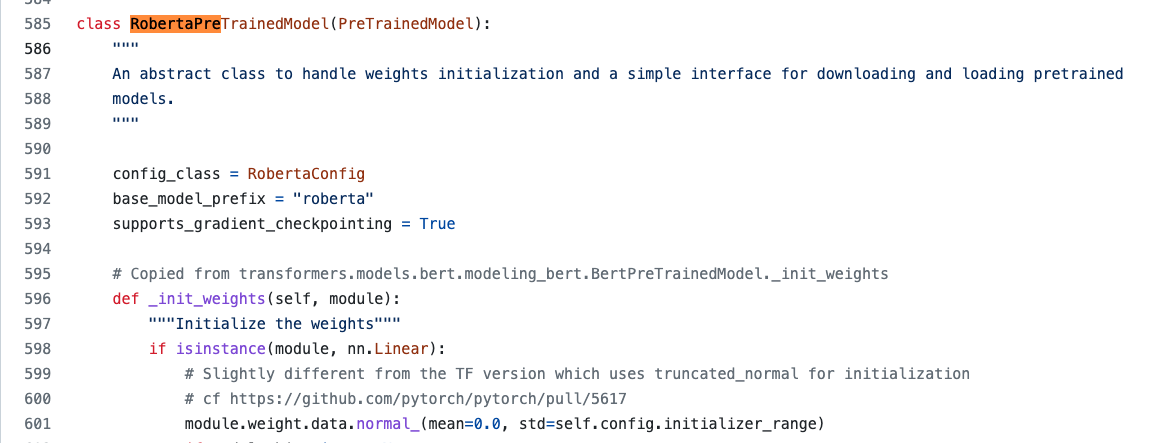

* `RobertaModel`은 위의 `RobertaPretrainedModel`을 상속받습니다. 해당 클래스에서 `RobertaEmbeddings`, `RobertaEncoder`, `RobertaPooler`를 선언합니다.

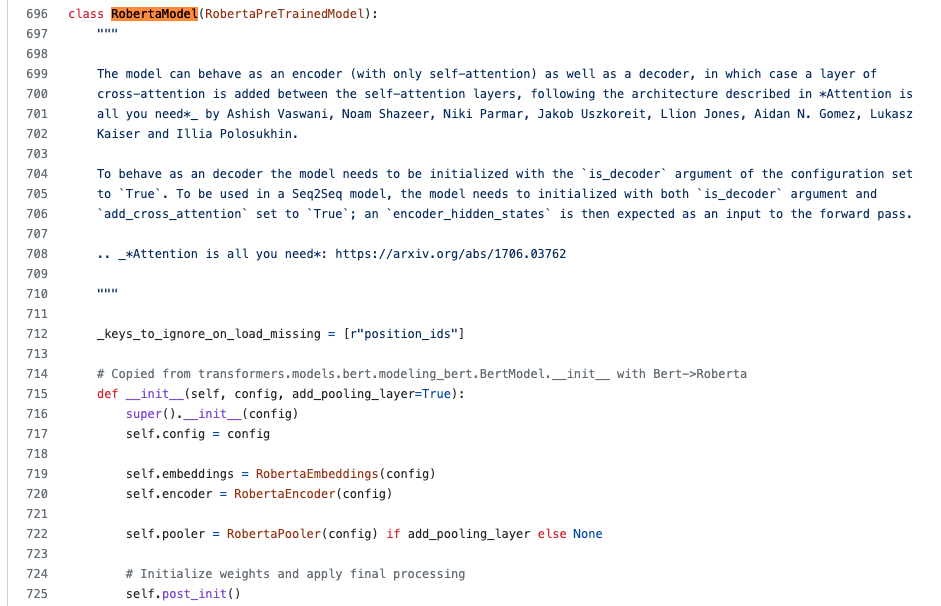

* `RobertaEmbeddings`, `RobertaEncoder`, `RobertaPooler` 모두 modeling_roberta 에 정의돼있습니다. 그외에 필요한 기능(e.g, selfattention) 등도 해당 파일에 정의돼있습니다. 너무 많아서 다 보진 않았습니다..
* 각 기능이 클래스로 정의돼있고, `forward` 아웃풋이 사전에 정의된 class type으로 반환됩니다. 다음 layer 에서 적절하게 이전 단계 아웃풋들을 선택해서 사용할 수 있는 용도인 것 같습니다. 
    * 이런 형태라서 오히려 entity typing 등을 적용할 때 어떻게 index 정보를 넘겨주는게 좋을지 고민입니다.
    * `Trainer` 부분에서 고쳐주는게 맞나? 싶구요. 고민입니다.
    
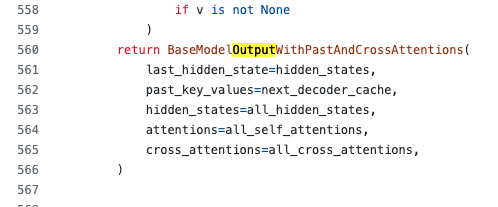

* 저희는 classifcation 을 수행하기 때문에 `RobertaForSequenceClassification` 을 사용합니다. 이 클래스는 마찬가지로 `RobertaPreTrained` 를 상속받고, `RobertaModel` 을 내부에서 선언합니다. 또한 classifier 도 해당 부분에서 `RobertaClassificationHead`로 선언합니다. 
    * lstm 추가 등의 classifier 꼭다리 변경은 이 부분에서 수행하게 될 것 같습니다.

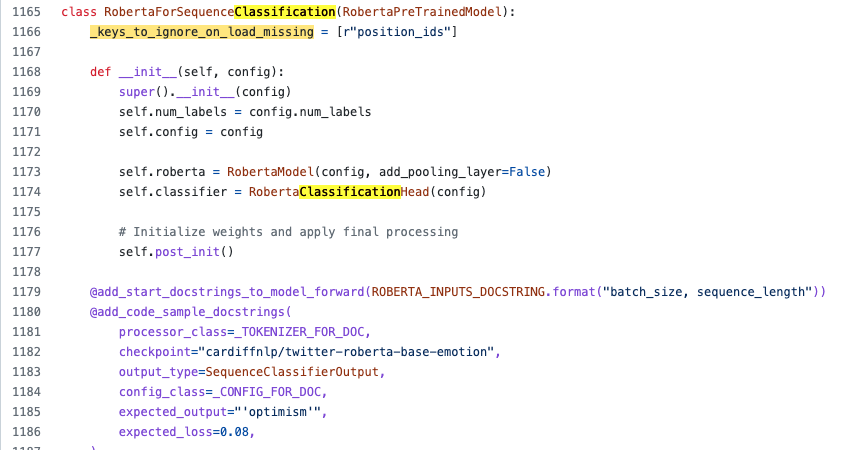

### RobertaEmbeddings
* 해당 클래스에서 embedding과 관련된 부분이 처리되고, `word_embeddings`, `position_embeddings`, `token_type_embeddings`가 선언됩니다. 아마 entity_type_embedding을 위해서 이부분의 수정이 필요하지 않을까 싶습니다.

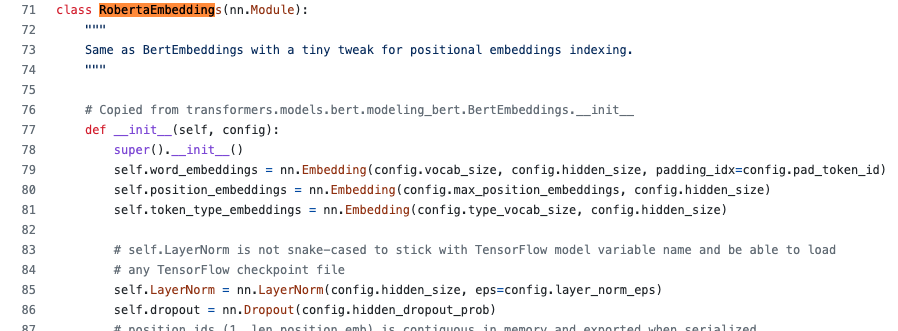


### RobertaPooler
* bert와 동일하게 Roberta도 문장 첫번째인 `CLS` 가 유의미한 vector일것이라 생각하고 사용합니다.
* 그렇기 때문에 `RobertaModel` 의 `__init__`의 flag `add_pooling_layer=True`로 돼있는데요.
* RobertaPooler 클래스를 보시면, hidden_states의 첫번째 token만 사용합니다. 즉, CLS 토큰만 사용하게 돼있습니다.
    * hidden_states dim 은 \[batch_size, token_sequence_length, hidden_dim\] 이기 때문에 `hidden_states[:, 0]` 은 첫번째 토큰만 사용하는 것입니다.
* 따라서, 저희가 sentence를 쪼갠 token sequence embedding을 모두 사용하려면, pooler를 사용 안하고, RobertaModel에서 추가 레이어를 생성해서 처리하는 것이 편리할 것입니다.
* Pooler 자체를 수정하면, `RobertaModel` 의 `forward`를 보면 pooler output이 따로 넘어가기 때문에.. 알수 없는 동작이 될 수도 잇을 것 같습니다. 동작이 의도대로 정확히 되신다면 여기서 수정하셔도 될 것 같습니다.

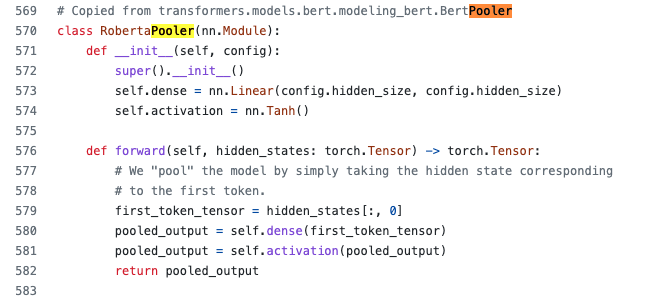

### RobertaForSequenceClassification
* 여기서 `RoberaModel`과 `RobertaClassificationHead`이 선언되고,`forward`를 보면 인풋이 들어오고 여기서 전체 forward propagation 이 수행됩니다.
* `forward`의 outputs 는 앞서 선언한 `RobertaModel`따라 다릅니다. 즉 `pooler`를 썼는지 아닌지에 따라 값이 다르게 나올겁니다.
* `forward`에서 loss가 계산되고, `loss,logits, hidden_states` 를 같이 넘겨줍니다. 
    * 저는 여기서 loss 변경을 하지 않고, Trainer 에서 `compute_loss` 부분에서 수정했습니다. 
    * 어차피 여기서 loss 계산 해도 optimize가 일어나진 않습니다.
    * `Trainer`의 `train` 에서 `loss.backward()` 와 `optimize`가 일어납니다.
    * 이때 어차피 `compute_loss`가 호출되더라구요? 그래서 거기서 고칩니다.

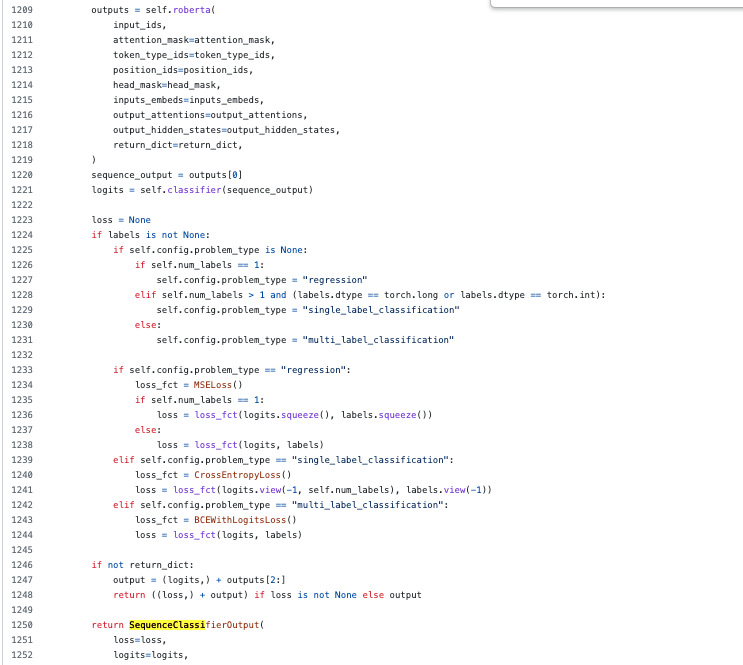

### 의아한 부분(일단 넘기셔도 됩니다.)
* huggingface 소스코드에서 modeling_utils.py 에 정의된 `PreTrainedModel`에 `post_init()`이 정의돼있는데요.
* `RobertaPreTrainedModel` 역시 이를 그대로 상속받음에도 불구하고
* 제가 커스텀 `RobertaModel`을 만들기 위해서 수정하려고 하면 `RobertaPreTrainedModel` 를 상속받은 `RobertaModel`을 정의해서 수정하면 `post_init()` 부를 수 없다고 뜹니다.
* 버전 문제인지 제가 놓친 부분이 있는지 모르겠으나, `PreTrainedModel`에서 사용한 `post_init()` 부분을 추가해서 `customRobertaModel` 을 수정하고 있습니다.

### 현재 수정하고 있는 방식
* `level2-klue-level2-nlp-03/KSY/models/` 에서 `custom_roberta.py` 에서 모델링 수정 중
    * 소스 코드에서 가져온거라 영어 docstring이 많습니다. 제가 수정중인 부분은 한글 또는 TODO 로 적어두었으니 참고하셔도 될 것 같아요.
* custom model이 점점 증가할 것 같아서 `get_model.py` 에서 argument에 따라 모델 반환하도록 만들 예정
* 모델에게 argument 넘겨줄 때 `args`로 주려면 계속 `args`를 넘겨줘야돼서 `train.py`의 config를 업데이트해서 사용하는 방식 사용 중(앞으로 조금씩 계속 수정될 것 같아요)

# Trainer 구조
* huggingface [source code](https://github.com/huggingface/transformers/blob/3dc82427166239e2764196c07fa4c5dcc25b1590/src/transformers/trainer.py)
* overriding, 특히 compute_loss [참고 코드](https://kyunghyunlim.github.io/nlp/ml_ai/2021/10/01/hf_culoss.html)

### train 흐름
* Trainer에 `def train` 에서 전체 forward propagation이 일어납니다.
* 앞 부분에는 이것저것 셋팅 부분이고 line 1370 부분 부터 epoch 돌아가는 익숙한 훈련 파이프라인이 진행됩니다.
* `training_step` 메소드가 호출되면 loss가 계산되고 optimize됩니다.
    * [deepspeed](https://github.com/microsoft/DeepSpeed)는 distributed training 고려한 optimize 도와주는 라이브러리

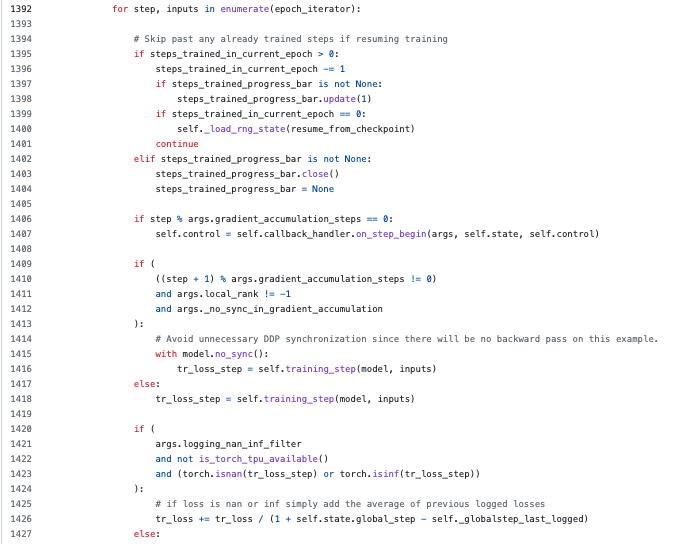

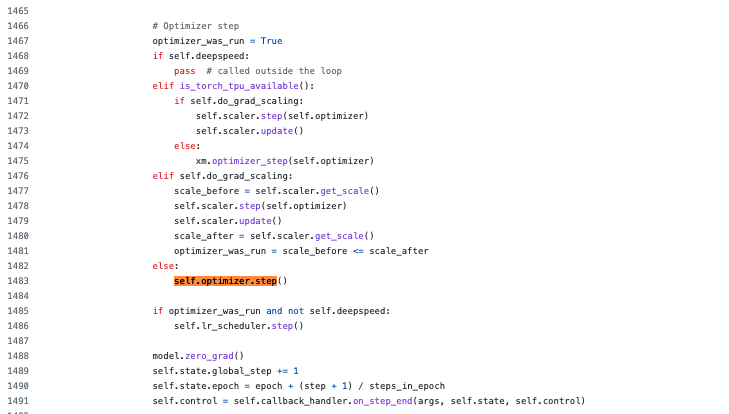

### Training steps
* `def train` 에서 실제 훈련을 수행하는 것은 `training_step` 입니다.

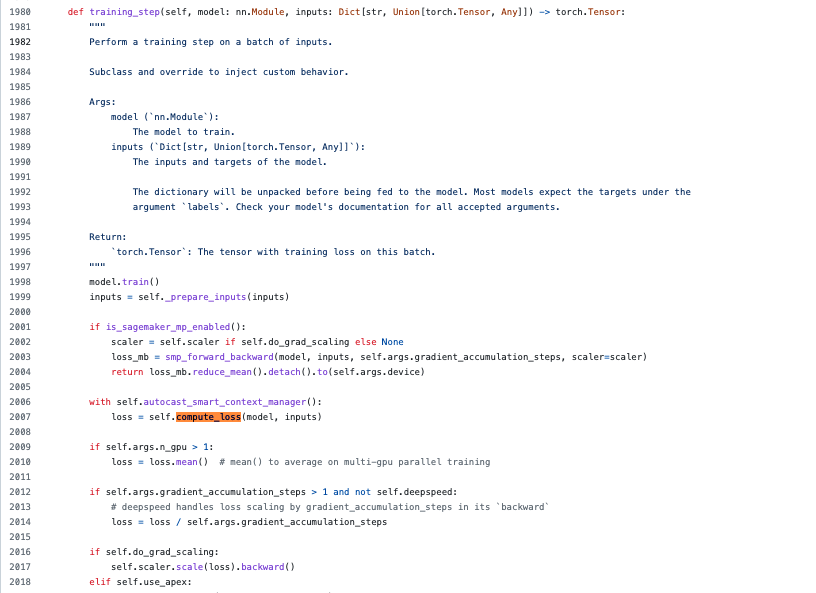

### Compute_loss
* input으로 모델, 인풋, 아웃풋이 들어와서 custom loss를 `self.smoother`로 변경해서 계산 가능합니다.

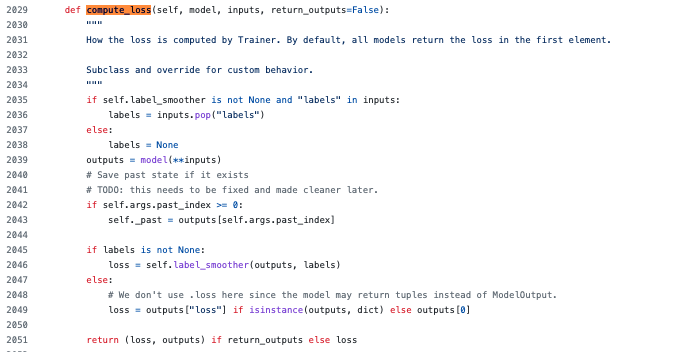

### 현재 수정하고 있는 방식
* `level2-klue-level2-nlp-03/KSY/custom/` 의 `trainer.py` 에서 `customTrainer2`를 보시면
* 현재 저는 confusion matrix 도 반환하고, 이 confusion matrix 는 `Fig` 타입이라 wandb에 반환해주려면 처리가 필요해서 `_maybe_log_save_evaluate` 도 변경하고 있습니다. 
    * loss만 변경할 시에는 이 부분 추가할 필요는 없습니다.
* `__init__` 에서 `self.labe_smoother`를 argument로 넘어온 loss_fn 타입에 해당하는 loss로 정의합니다. 
* 그 loss로 compute_loss 에서 계산돼고 최종 loss 를 반환합니다.

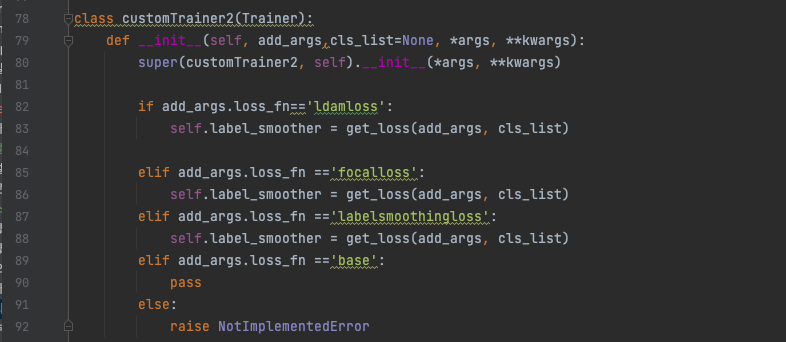

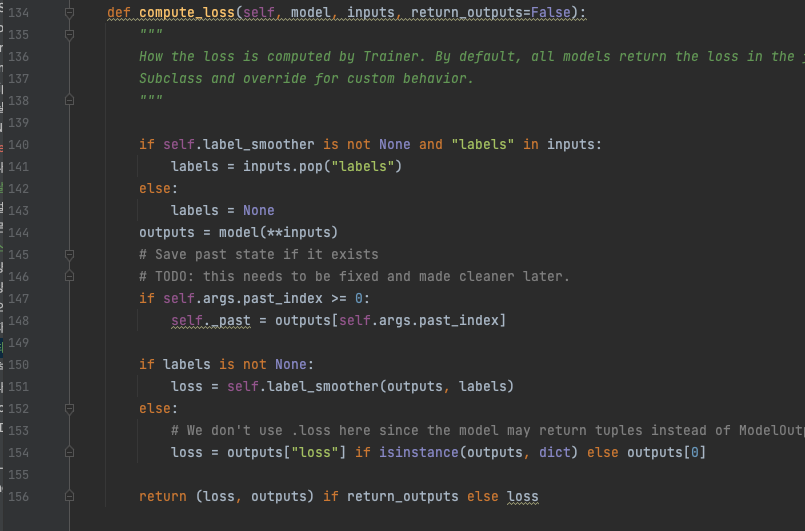

### loss 를 바꾸기 위해 해야하는 것
* 모든 loss 관련된 부분은 `loss.py` 에 정의돼있습니다. 
* 위의 Trainer 선언시 `__init__` 에 있는 `get_loss` 호출을 위해서 args와 `cls_num_list`를 넣어줍니다.
    * focal loss, ldam loss 적용을 위해 `cls_num_list`를 넣어주는게 필요합니다.
    * focal, labelsmoothing에 사용되는 하이퍼파라미터는 `arguments.py` 에 추가해서 썼습니다.
    * 나중에 하이퍼파라미터 search 할 필요는 있을 것 같습니다.
* 이 값들을 넣어주기 위해 Trainer 선언 부분을 아래와 같이 해두었습니다. 저는 파일을 따로 만들어서 `train_custom.py` 에 정의했습니다. 해당 파일 참고하시면 될 것 같습니다.
* `cls_list` 는 클래스별 데이터 갯수를 담은 리스트입니다. `get_cls_list` 함수는 `load_data.py`에 정의돼있습니다.

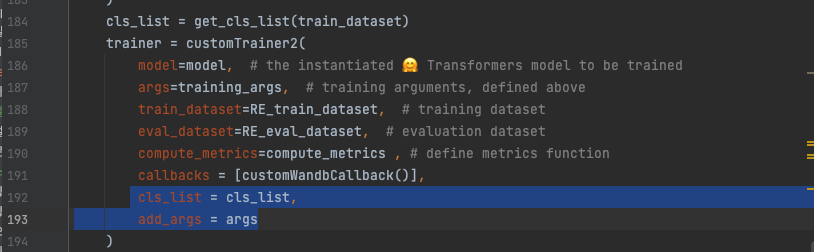